# **BUSINESS CASE 2: SIEMENS ADVANTA SALES FORECASTING**  


## 🎓 Master’s Program in Data Science & Advanced Analytics 
**Nova IMS** | March 2025   
**Course:** Business Cases with Data Science

## 👥 Team **Group Z**  
- **Alice Viegas** | 20240572  
- **Bernardo Faria** | 20240579  
- **Dinis Pinto** | 20240612  

## 📊 Project Overview  
This notebook utilizes the following datasets:  
- **Case2_Sales Data.csv**:  Daily sales data per GCK (product groups) in EUR
- **Case2_Market Data.xlsx**: Important macro-economic indices for Siemens in its most important countries
- **Case2_Test Set Template.xlsx**: Template for the test set submission

The goal of this project is to forecast the sales of some selected product groups of Siemens in Germany.

 ## 1. Initial setup and modules/packages loading

In [ ]:
# Packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import shapiro
from statsmodels.tsa.stattools import adfulle

In [2]:
#!pip install openpyxl

In [3]:
# Global definitions
baseFolder = os.getcwd()
exportsFolder = baseFolder + os.sep +'Exports' + os.sep

In [4]:
subPlots_Title_fontSize = 12
subPlots_xAxis_fontSize = 10
subPlots_yAxis_fontSize = 10
subPlots_label_fontSize = 10
heatmaps_text_fontSize = 8

plots_Title_fontSize = 14
plots_Title_textColour = 'black'

plots_Legend_fontSize = 12
plots_Legend_textColour = 'black'

plots_barTexts_fontSize = 8

## 2. Importing Data

In [5]:
sales_data = pd.read_csv('Case2_Sales Data.csv', sep=';')
market_data = pd.read_excel('Case2_Market Data.xlsx')

## 3. Data Understanding/Preparation

In [6]:
df_sales = sales_data.copy()
df_market = market_data.copy()

In [7]:
pd.set_option('display.max_columns', None)  # Displays all columns

### 3.1. Sales Data

In [8]:
df_sales.shape

(9802, 3)

In [9]:
df_sales.head()

,DATE,Mapped_GCK,Sales_EUR
0,01.10.2018,#1,0
1,02.10.2018,#1,0
2,03.10.2018,#1,0
3,04.10.2018,#1,0
4,05.10.2018,#1,0


In [10]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9802 entries, 0 to 9801
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   DATE        9802 non-null   object
 1   Mapped_GCK  9802 non-null   object
 2   Sales_EUR   9802 non-null   object
dtypes: object(3)
memory usage: 229.9+ KB


In [11]:
df_sales.describe().T

,count,unique,top,freq
DATE,9802,1216,30.09.2019,14
Mapped_GCK,9802,14,#1,1179
Sales_EUR,9802,2609,0,7134


In [12]:
df_sales.duplicated().sum()

np.int64(0)

We can see there are no missing values or duplicates, but the features are not in the correct formats.   
We will need to correct these before proceeding with the analysis.
Additionally, the data is daily, but we need to forecast monthly sales. We will need to aggregate the data accordingly.


In [13]:
df_sales['Sales_EUR']= df_sales['Sales_EUR'].apply(lambda x : x.replace(',', '.')).astype(float)  # Replace comma with dot and convert to float

In [14]:
df_sales['DATE'] = df_sales['DATE'].apply(lambda x : pd.to_datetime(x, format='%d.%m.%Y'))  # Convert to datetime

In [15]:
df_sales['DATE'] = df_sales['DATE'].dt.to_period('M')  # Convert to month

# Aggregating the sales on a monthly basis
df_sales = df_sales.groupby(['DATE', 'Mapped_GCK']).agg({'Sales_EUR': 'sum'}).reset_index()

In [16]:
# Remove the # from the 'Mapped_GCK' column for data cleanliness and ease of processing
# Convert 'Mapped_GCK' to integer as it is a categorical numeric identifier for Product Groups
df_sales['Mapped_GCK'] = df_sales['Mapped_GCK'].str[1:].astype(int)

In [17]:
df_sales.shape

(602, 3)

In [18]:
df_sales.head()

,DATE,Mapped_GCK,Sales_EUR
0,2018-10,1,36098918.79
1,2018-10,11,1021303.50
2,2018-10,12,28686.33
3,2018-10,13,27666.10
4,2018-10,14,5770.00


In [19]:
df_sales.describe()

,Mapped_GCK,Sales_EUR
count,602.000000,6.020000e+02
mean,11.285714,4.441603e+06
std,8.588083,9.743326e+06
min,1.000000,-1.520296e+04
25%,5.000000,1.376013e+04
50%,10.000000,2.911755e+05
75%,14.000000,1.591996e+06
max,36.000000,4.448301e+07


In [20]:
#check how many rows have negative values for sales
df_sales[df_sales['Sales_EUR'] < 0]

,DATE,Mapped_GCK,Sales_EUR
221,2020-01,6,-15202.96
256,2020-04,14,-2851.45
363,2020-11,9,-4358.10
494,2021-09,14,-561.25


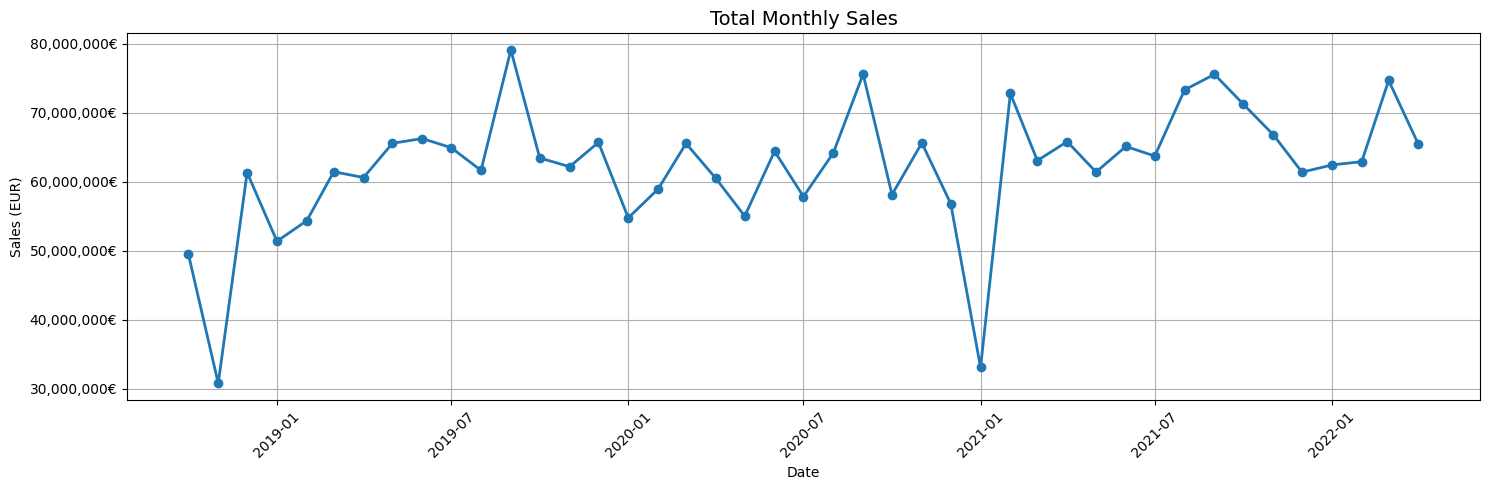

In [21]:
df_sales['DATE'] = df_sales['DATE'].dt.to_timestamp()  # Convert to timestamp for visualizations

plt.figure(figsize=(15, 5))

plt.plot(df_sales.groupby('DATE')['Sales_EUR'].sum(), marker='o', linewidth=2)
plt.title('Total Monthly Sales', fontsize=plots_Title_fontSize, color=plots_Title_textColour)
plt.xlabel('Date', fontsize=subPlots_label_fontSize)
plt.ylabel('Sales (EUR)', fontsize=subPlots_label_fontSize)

# Format y-axis to show values in millions
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}€')) 

plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

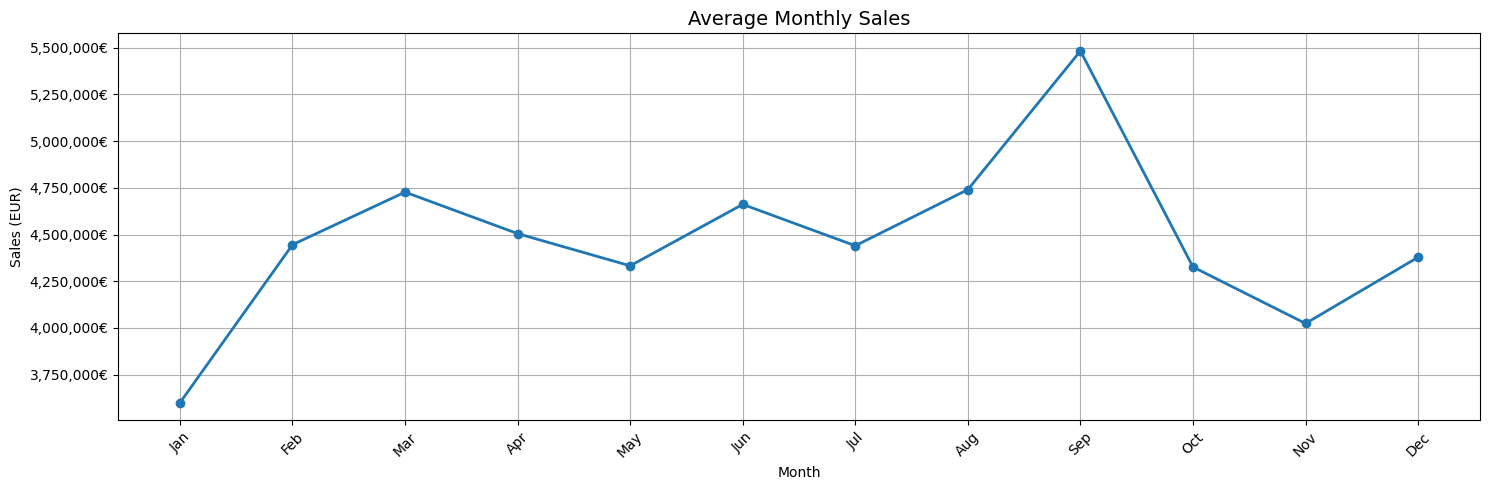

In [22]:
plt.figure(figsize=(15, 5))

plt.plot(df_sales.groupby(df_sales['DATE'].dt.month)['Sales_EUR'].mean(), marker='o', linewidth=2)
plt.title('Average Monthly Sales', fontsize=plots_Title_fontSize, color=plots_Title_textColour)
plt.xlabel('Month', fontsize=subPlots_label_fontSize)
plt.ylabel('Sales (EUR)', fontsize=subPlots_label_fontSize)

# Format y-axis to show values in millions
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}€'))

# Replace x-ticks with month names
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

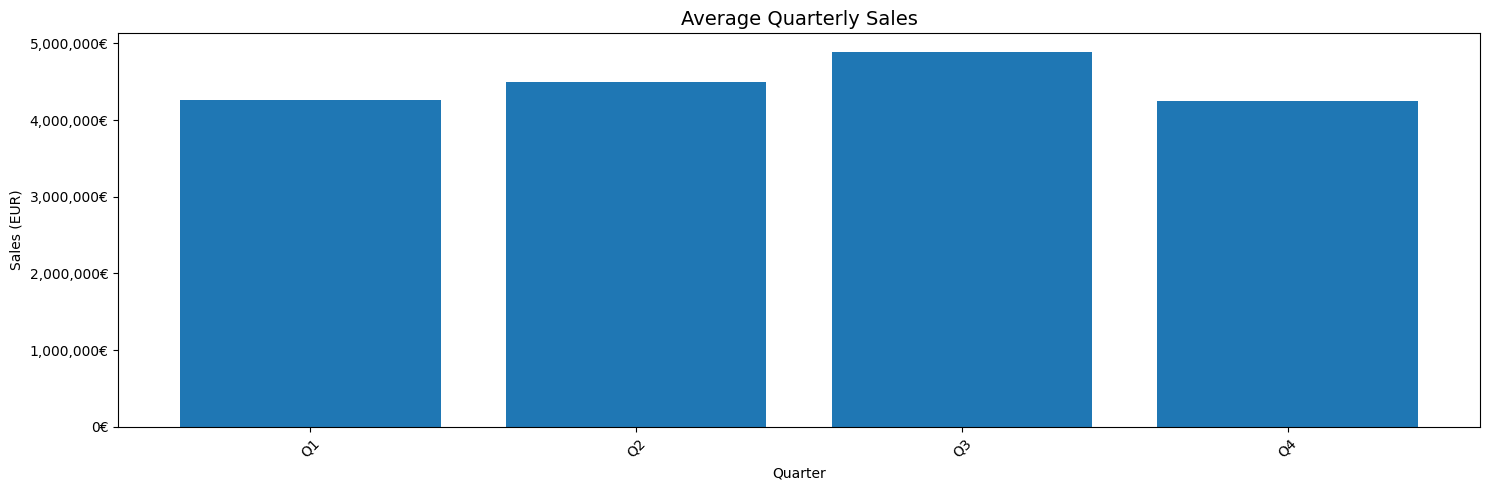

In [23]:
trimester_labels = {
    1: 'Q1', 2: 'Q1', 3: 'Q1', 
    4: 'Q2', 5: 'Q2', 6: 'Q2',
    7: 'Q3', 8: 'Q3', 9: 'Q3',
    10: 'Q4', 11: 'Q4', 12: 'Q4'
}

quarterly_sales = df_sales.groupby(df_sales['DATE'].dt.month.map(trimester_labels))['Sales_EUR'].mean().reset_index()

plt.figure(figsize=(15, 5))

plt.bar(quarterly_sales['DATE'], quarterly_sales['Sales_EUR'])
plt.title('Average Quarterly Sales', fontsize=plots_Title_fontSize, color=plots_Title_textColour)
plt.xlabel('Quarter', fontsize=subPlots_label_fontSize)
plt.ylabel('Sales (EUR)', fontsize=subPlots_label_fontSize)

# Format y-axis to show values in millions
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}€'))

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


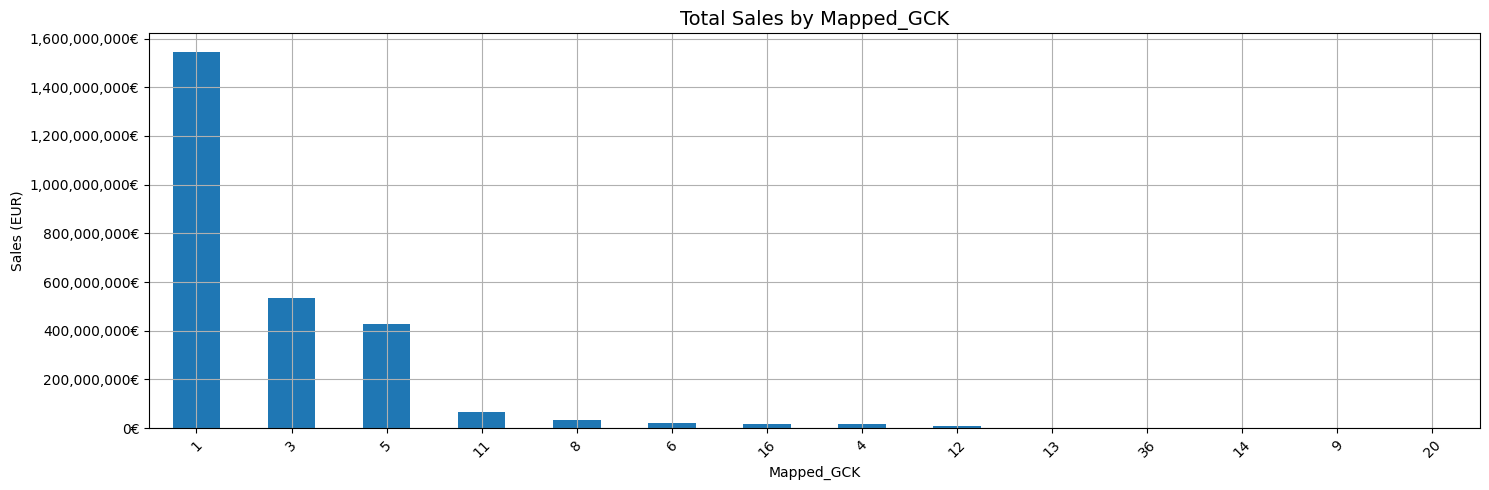

In [24]:
df_sales.groupby('Mapped_GCK')['Sales_EUR'].sum().sort_values(ascending=False).plot(kind='bar', figsize=(15, 5))

plt.title('Total Sales by Mapped_GCK', fontsize=plots_Title_fontSize, color=plots_Title_textColour)
plt.xlabel('Mapped_GCK', fontsize=subPlots_label_fontSize)
plt.ylabel('Sales (EUR)', fontsize=subPlots_label_fontSize)

# Format y-axis to show values in millions
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}€'))

plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

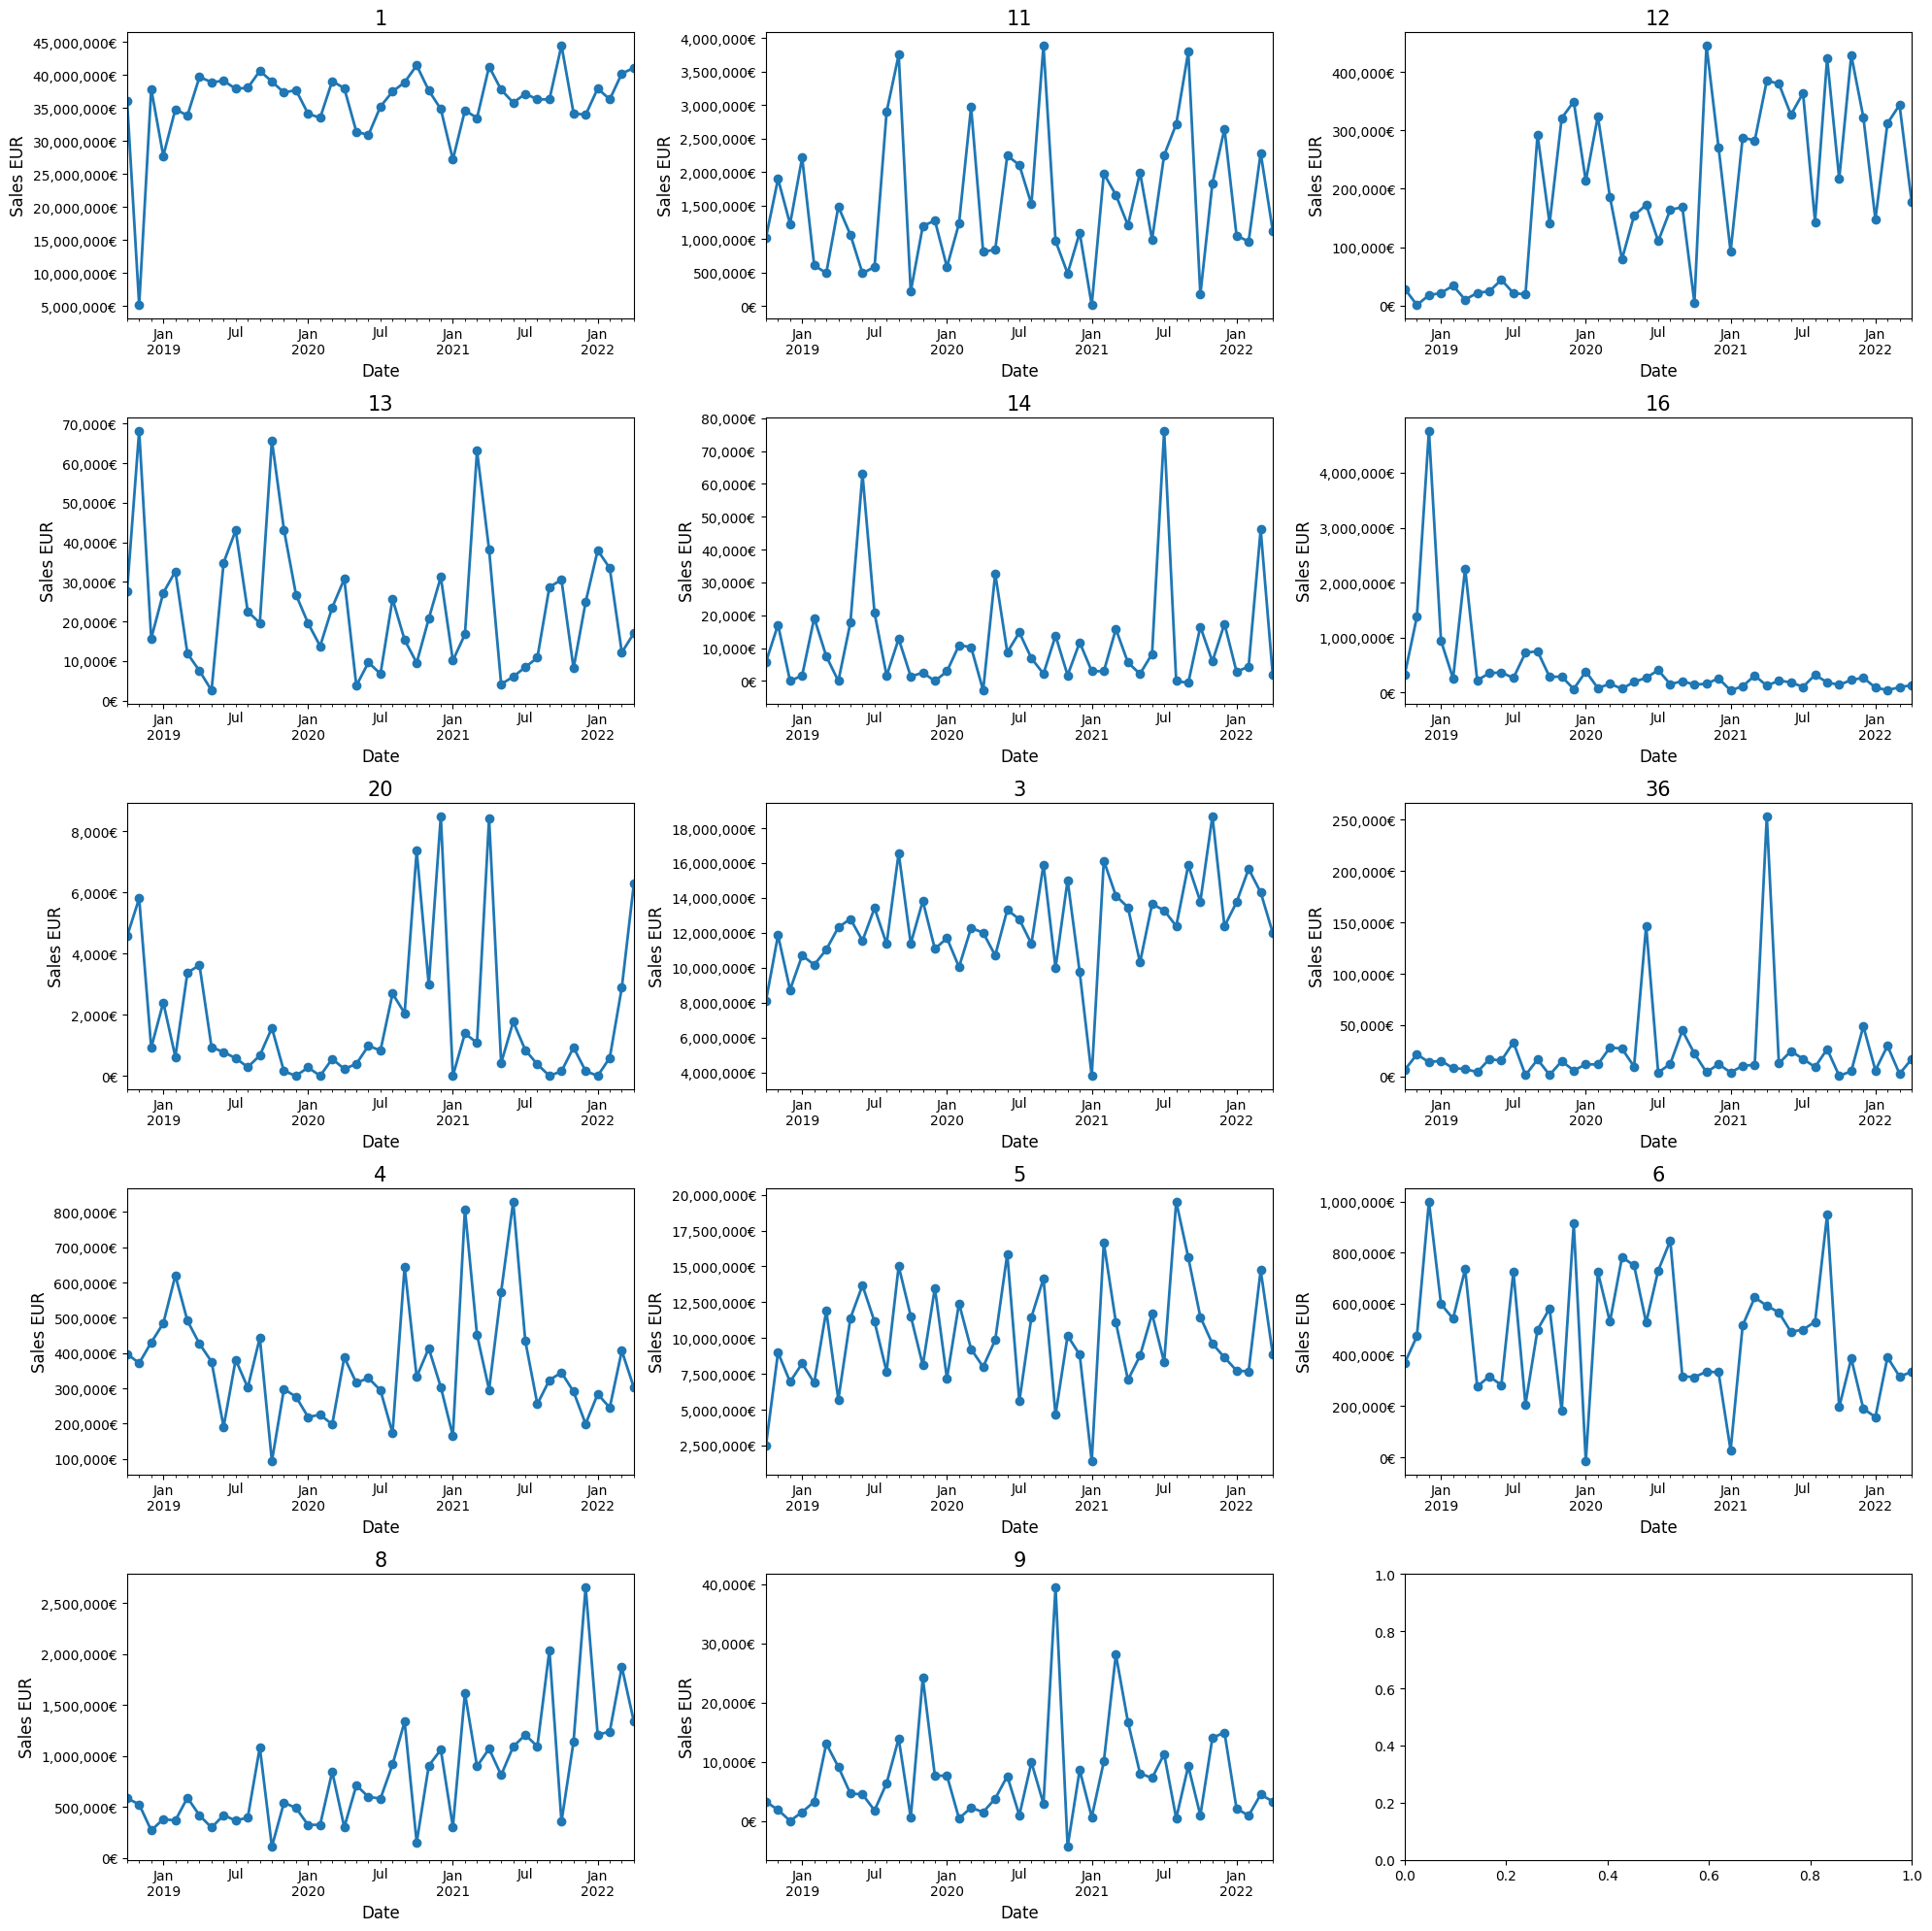

In [25]:
# Create a 5x3 grid of subplots
fig, ax = plt.subplots(5, 3, figsize=(20, 20))

# Flatten the axes array to easily loop through
ax = ax.flatten()

# Loop over the unique values of 'Mapped_GCK' and plot the corresponding data
for i, gck in enumerate(df_sales['Mapped_GCK'].unique()):
    # Filter the data for the current 'Mapped_GCK'
    subset = df_sales[df_sales['Mapped_GCK'] == gck]
    
    # Group by 'DATE' and sum the 'Sales_EUR'
    subset.groupby('DATE')['Sales_EUR'].sum().plot(kind='line', ax=ax[i], marker='o', linewidth=2)
    
    # Set the title and labels for each subplot
    ax[i].set_title(f'{gck}', fontsize=15)  
    ax[i].set_xlabel('Date', fontsize=12) 
    ax[i].set_ylabel('Sales EUR', fontsize=12)

    # Format y-axis to show values in millions
    ax[i].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}€'))

# Adjust layout to prevent overlap of labels and titles
plt.tight_layout()

# Display the plot
plt.show()

### 3.2. Market Data

In [26]:
df_market.head()

,Unnamed: 0,China,China.1,France,France.1,Germany,Germany.1,Italy,Italy.1,Japan,Japan.1,Switzerland,Switzerland.1,United Kingdom,United Kingdom.1,United States,United States.1,Europe,Europe.1,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Producer Prices,Producer Prices.1,Producer Prices.2,Producer Prices.3,Producer Prices.4,Producer Prices.5,production index,production index.1,production index.2,production index.3,production index.4,production index.5,production index.6,production index.7,production index.8,production index.9,production index.10,production index.11,production index.12,production index.13,production index.14,production index.15
0,Index 2010=100 (if not otherwise noted),Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,World: Price of Base Metals,World: Price of Energy,World: Price of Metals & Minerals,World: Price of Natural gas index,"World: Price of Crude oil, average",World: Price of Copper,United States: EUR in LCU,United States: Electrical equipment,United Kingdom: Electrical equipment,Italy: Electrical equipment,France: Electrical equipment,Germany: Electrical equipment,China: Electrical equipment,United States: Machinery and equipment n.e.c.,World: Machinery and equipment n.e.c.,Switzerland: Machinery and equipment n.e.c.,United Kingdom: Machinery and equipment n.e.c.,Italy: Machinery and equipment n.e.c.,Japan: Machinery and equipment n.e.c.,France: Machinery and equipment n.e.c.,Germany: Machinery and equipment n.e.c.,United States: Electrical equipment,World: Electrical equipment,Switzerland: Electrical equipment,United Kingdom: Electrical equipment,Italy: Electrical equipment,Japan: Electrical equipment,France: Electrical equipment,Germany: Electrical equipment
1,date,MAB_ELE_PRO156,MAB_ELE_SHP156,MAB_ELE_PRO250,MAB_ELE_SHP250,MAB_ELE_PRO276,MAB_ELE_SHP276,MAB_ELE_PRO380,MAB_ELE_SHP380,MAB_ELE_PRO392,MAB_ELE_SHP392,MAB_ELE_PRO756,MAB_ELE_SHP756,MAB_ELE_PRO826,MAB_ELE_SHP826,MAB_ELE_PRO840,MAB_ELE_SHP840,MAB_ELE_PRO1100,MAB_ELE_SHP1100,RohiBASEMET1000_org,RohiENERGY1000_org,RohiMETMIN1000_org,RohiNATGAS1000_org,RohCRUDE_PETRO1000_org,RohCOPPER1000_org,WKLWEUR840_org,PRI27840_org,PRI27826_org,PRI27380_org,PRI27250_org,PRI27276_org,PRI27156_org,PRO28840_org,PRO281000_org,PRO28756_org,PRO28826_org,PRO28380_org,PRO28392_org,PRO28250_org,PRO28276_org,PRO27840_org,PRO271000_org,PRO27756_org,PRO27826_org,PRO27380_org,PRO27392_org,PRO27250_org,PRO27276_org
2,2004m2,16.940704,16.940704,112.091273,83.458866,82.623037,79.452532,124.289603,86.560493,109.33401,110.495272,91.221862,89.987275,111.353812,73.601265,107.6014,79.24023,97.122911,80.09853,54.039811,44.123338,48.747945,87.076974,39.639458,36.623832,1.2646,78.969864,80.757423,93.020027,NaN,93.230453,NaN,102.491722,97.597374,97.1,106.191977,116.790276,110.890034,118.274109,80.82901,117.723991,NaN,81.1,120.706516,141.510864,106.161262,102.077057,85.9132
3,2004m3,23.711852,23.711852,136.327976,106.168192,100.556582,97.012918,143.411662,106.344544,140.884616,144.686166,85.866287,79.883583,127.558608,84.047595,110.187364,98.619024,113.783904,96.015929,54.666162,47.588957,49.256157,87.192705,42.592034,39.931055,1.2262,79.673569,80.962135,93.540268,NaN,93.335678,NaN,105.62748,113.224892,91.195116,121.625075,139.288391,141.176853,148.121841,102.130104,119.220779

In [27]:
df_market.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221 entries, 0 to 220
Data columns (total 48 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Unnamed: 0           221 non-null    object
 1   China                221 non-null    object
 2   China.1              221 non-null    object
 3   France               221 non-null    object
 4   France.1             221 non-null    object
 5   Germany              221 non-null    object
 6   Germany.1            221 non-null    object
 7   Italy                221 non-null    object
 8   Italy.1              221 non-null    object
 9   Japan                221 non-null    object
 10  Japan.1              221 non-null    object
 11  Switzerland          220 non-null    object
 12  Switzerland.1        220 non-null    object
 13  United Kingdom       221 non-null    object
 14  United Kingdom.1     203 non-null    object
 15  United States        221 non-null    object
 16  United S

In [28]:
info_market = df_market.iloc[0:2]
df_market = df_market.iloc[2:]

In [29]:
info_market

,Unnamed: 0,China,China.1,France,France.1,Germany,Germany.1,Italy,Italy.1,Japan,Japan.1,Switzerland,Switzerland.1,United Kingdom,United Kingdom.1,United States,United States.1,Europe,Europe.1,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Producer Prices,Producer Prices.1,Producer Prices.2,Producer Prices.3,Producer Prices.4,Producer Prices.5,production index,production index.1,production index.2,production index.3,production index.4,production index.5,production index.6,production index.7,production index.8,production index.9,production index.10,production index.11,production index.12,production index.13,production index.14,production index.15
0,Index 2010=100 (if not otherwise noted),Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,World: Price of Base Metals,World: Price of Energy,World: Price of Metals & Minerals,World: Price of Natural gas index,"World: Price of Crude oil, average",World: Price of Copper,United States: EUR in LCU,United States: Electrical equipment,United Kingdom: Electrical equipment,Italy: Electrical equipment,France: Electrical equipment,Germany: Electrical equipment,China: Electrical equipment,United States: Machinery and equipment n.e.c.,World: Machinery and equipment n.e.c.,Switzerland: Machinery and equipment n.e.c.,United Kingdom: Machinery and equipment n.e.c.,Italy: Machinery and equipment n.e.c.,Japan: Machinery and equipment n.e.c.,France: Machinery and equipment n.e.c.,Germany: Machinery and equipment n.e.c.,United States: Electrical equipment,World: Electrical equipment,Switzerland: Electrical equipment,United Kingdom: Electrical equipment,Italy: Electrical equipment,Japan: Electrical equipment,France: Electrical equipment,Germany: Electrical equipment
1,date,MAB_ELE_PRO156,MAB_ELE_SHP156,MAB_ELE_PRO250,MAB_ELE_SHP250,MAB_ELE_PRO276,MAB_ELE_SHP276,MAB_ELE_PRO380,MAB_ELE_SHP380,MAB_ELE_PRO392,MAB_ELE_SHP392,MAB_ELE_PRO756,MAB_ELE_SHP756,MAB_ELE_PRO826,MAB_ELE_SHP826,MAB_ELE_PRO840,MAB_ELE_SHP840,MAB_ELE_PRO1100,MAB_ELE_SHP1100,RohiBASEMET1000_org,RohiENERGY1000_org,RohiMETMIN1000_org,RohiNATGAS1000_org,RohCRUDE_PETRO1000_org,RohCOPPER1000_org,WKLWEUR840_org,PRI27840_org,PRI27826_org,PRI27380_org,PRI27250_org,PRI27276_org,PRI27156_org,PRO28840_org,PRO281000_org,PRO28756_org,PRO28826_org,PRO28380_org,PRO28392_org,PRO28250_org,PRO28276_org,PRO27840_org,PRO271000_org,PRO27756_org,PRO27826_org,PRO27380_org,PRO27392_org,PRO27250_org,PRO27276_org


In [30]:
info_market = info_market.transpose().reset_index()
info_market.columns = info_market.iloc[0]
info_market = info_market[1:]  # Drop the old header row
info_market = info_market.rename(columns={info_market.columns[0]: 'Region', info_market.columns[1]: 'Index Name', info_market.columns[2]: 'Index Code'})
info_market.reset_index(drop=True, inplace=True)

In [31]:
info_market

,Region,Index Name,Index Code
0,China,Production Index Machinery & Electricals,MAB_ELE_PRO156
1,China.1,Shipments Index Machinery & Electricals,MAB_ELE_SHP156
2,France,Production Index Machinery & Electricals,MAB_ELE_PRO250
3,France.1,Shipments Index Machinery & Electricals,MAB_ELE_SHP250
4,Germany,Production Index Machinery & Electricals,MAB_ELE_PRO276
5,Germany.1,Shipments Index Machinery & Electricals,MAB_ELE_SHP276
6,Italy,Production Index Machinery & Electricals,MAB_ELE_PRO380
7,Italy.1,Shipments Index Machinery & Electricals,MAB_ELE_SHP380
8,Japan,Production Index Machinery & Electricals,MAB_ELE_PRO392
9,Japan.1,Shipments Index Machinery & Electricals,MAB_ELE_SHP392


In [32]:
# Lets give a more consistent formating to the info_market dataframe
for idx, row in  info_market.iterrows():
    region = row['Region']
    index_name = row['Index Name']
    
 # Extract Region from Index Name if needed
    if ':' in index_name:
        info_market.at[idx, 'Region'] = index_name.split(':')[0].strip()
        info_market.at[idx, 'Index Name'] = index_name.split(':')[1].strip()
    
    # Remove decimal suffixes from Region
    if '.' in region:
        info_market.at[idx, 'Region'] = row['Region'].split('.')[0].strip()
    
info_market.sort_values('Region').reset_index(drop=True) 

,Region,Index Name,Index Code
0,China,Production Index Machinery & Electricals,MAB_ELE_PRO156
1,China,Shipments Index Machinery & Electricals,MAB_ELE_SHP156
2,China,Electrical equipment,PRI27156_org
3,Europe,Shipments Index Machinery & Electricals,MAB_ELE_SHP1100
4,Europe,Production Index Machinery & Electricals,MAB_ELE_PRO1100
5,France,Production Index Machinery & Electricals,MAB_ELE_PRO250
6,France,Shipments Index Machinery & Electricals,MAB_ELE_SHP250
7,France,Machinery and equipment n.e.c.,PRO28250_org
8,France,Electrical equipment,PRI27250_org
9,France,Electrical equipment,PRO27250_org


In [33]:
info_market.describe()

,Region,Index Name,Index Code
count,47,47,47
unique,10,11,47
top,World,Electrical equipment,MAB_ELE_PRO156
freq,8,14,1


Within Index Code, there is a Region Code and a Name Code.

In [34]:
df_market.columns = market_data.iloc[1] 

In [35]:
df_market

1,date,MAB_ELE_PRO156,MAB_ELE_SHP156,MAB_ELE_PRO250,MAB_ELE_SHP250,MAB_ELE_PRO276,MAB_ELE_SHP276,MAB_ELE_PRO380,MAB_ELE_SHP380,MAB_ELE_PRO392,MAB_ELE_SHP392,MAB_ELE_PRO756,MAB_ELE_SHP756,MAB_ELE_PRO826,MAB_ELE_SHP826,MAB_ELE_PRO840,MAB_ELE_SHP840,MAB_ELE_PRO1100,MAB_ELE_SHP1100,RohiBASEMET1000_org,RohiENERGY1000_org,RohiMETMIN1000_org,RohiNATGAS1000_org,RohCRUDE_PETRO1000_org,RohCOPPER1000_org,WKLWEUR840_org,PRI27840_org,PRI27826_org,PRI27380_org,PRI27250_org,PRI27276_org,PRI27156_org,PRO28840_org,PRO281000_org,PRO28756_org,PRO28826_org,PRO28380_org,PRO28392_org,PRO28250_org,PRO28276_org,PRO27840_org,PRO271000_org,PRO27756_org,PRO27826_org,PRO27380_org,PRO27392_org,PRO27250_org,PRO27276_org
2,2004m2,16.940704,16.940704,112.091273,83.458866,82.623037,79.452532,124.289603,86.560493,109.33401,110.495272,91.221862,89.987275,111.353812,73.601265,107.6014,79.24023,97.122911,80.09853,54.039811,44.123338,48.747945,87.076974,39.639458,36.623832,1.2646,78.969864,80.757423,93.020027,NaN,93.230453,NaN,102.491722,97.597374,97.1,106.191977,116.790276,110.890034,118.274109,80.82901,117.723991,NaN,81.1,120.706516,141.510864,106.161262,102.077057,85.9132
3,2004m3,23.711852,23.711852,136.327976,106.168192,100.556582,97.012918,143.411662,106.344544,140.884616,144.686166,85.866287,79.883583,127.558608,84.047595,110.187364,98.619024,113.783904,96.015929,54.666162,47.588957,49.256157,87.192705,42.592034,39.931055,1.2262,79.673569,80.962135,93.540268,NaN,93.335678,NaN,105.62748,113.224892,91.195116,121.625075,139.288391,141.176853,148.121841,102.130104,119.220779,NaN,76.690307,138.30955,152.880234,140.288741,117.225685,97.670815
4,2004m4,24.435235,24.435235,117.791806,92.007646,89.653203,84.932358,129.083828,95.579673,105.853579,102.655769,85.622508,79.740802,108.732297,73.026027,108.166564,89.774031,101.715199,85.167236,54.872715,47.779013,49.423751,91.379923,42.650637,39.134854,1.1985,80.337639,80.757423,93.852425,NaN,93.440903,NaN,103.484955,100.16909,93.793535,104.965505,125.289566,105.648765,125.482231,90.961426,117.441124,NaN,71.552403,115.55733,137.796875,106.271197,105.335777,87.253983
5,2004m5,23.708115,23.708115,109.002541,85.696486,86.880571,82.372794,135.590391,100.087039,101.864777,100.305285,85.378729,79.598021,110.6452,74.591883,108.425887,87.463813,101.275727,84.485767,51.230356,53.590898,46.468392,99.04452,47.517121,36.278433,1.2007,80.798828,80.757423,93.852425,NaN,93.546127,NaN,103.643944,99.581436,96.391954,105.885359,131.988998,101.990361,116.64975,88.082901,117.899216,NaN,66.4145,119.269534,143.860535,101.60871,96.616508,84.675552
6,2004m6,27.009138,27.009138,133.785737,106.641482,99.010814,95.10874,136.424935,110.889719,120.33292,119.61638,85.13495,79.455239,122.02096,82.343346,110.569933,97.364496,112.057197,96.963294,52.876331,50.799575,47.803913,98.636267,44.967605,35.65738,1.2138,80.91349,80.552711,93.956467,NaN,93.440903,NaN,106.062668,109.27771,98.990373,118.252278,132.988922,122.136575,143.248734,100.978699,119.499107,NaN,61.276596,128.849416,144.315308,116.655248,118.45871,95.401802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216,2021m12,310.763183,310.763183,100.565744,134.589504,118.103281,149.364286,94.006826,150.482735,127.771735,131.029703,106.704029,104.819189,101.273544,NaN,107.040766,148.590371,123.076659,150.046922,125.20703,112.372958,116.715183,236.488368,92.188708,126.76124,1.1304,128.511261,NaN,113.309631,108.18251,115.748863,98.1062,105.736748,134.598755,102.27753,90.350055,103.191399,136.975506,112.791885,129.188248,109.624107,132.281006,114.326241,121.065762,72.915611,109.005151,80.763306,97.773956
217,2022m1,235.956129,235.956129,85.743503,108.15632,94.55061,120.353403,86.851008,101.258277,110.460181,110.823532,103.49926,101.70157,95.003541,NaN,111.052133,129.565798,103.199827,120.338095,133.219393,121.309886,125.229641,196.91114,106.173052,129.829146,1

In [36]:
df_market.shape

(219, 48)

In [37]:
df_market.head()

1,date,MAB_ELE_PRO156,MAB_ELE_SHP156,MAB_ELE_PRO250,MAB_ELE_SHP250,MAB_ELE_PRO276,MAB_ELE_SHP276,MAB_ELE_PRO380,MAB_ELE_SHP380,MAB_ELE_PRO392,MAB_ELE_SHP392,MAB_ELE_PRO756,MAB_ELE_SHP756,MAB_ELE_PRO826,MAB_ELE_SHP826,MAB_ELE_PRO840,MAB_ELE_SHP840,MAB_ELE_PRO1100,MAB_ELE_SHP1100,RohiBASEMET1000_org,RohiENERGY1000_org,RohiMETMIN1000_org,RohiNATGAS1000_org,RohCRUDE_PETRO1000_org,RohCOPPER1000_org,WKLWEUR840_org,PRI27840_org,PRI27826_org,PRI27380_org,PRI27250_org,PRI27276_org,PRI27156_org,PRO28840_org,PRO281000_org,PRO28756_org,PRO28826_org,PRO28380_org,PRO28392_org,PRO28250_org,PRO28276_org,PRO27840_org,PRO271000_org,PRO27756_org,PRO27826_org,PRO27380_org,PRO27392_org,PRO27250_org,PRO27276_org
2,2004m2,16.940704,16.940704,112.091273,83.458866,82.623037,79.452532,124.289603,86.560493,109.33401,110.495272,91.221862,89.987275,111.353812,73.601265,107.6014,79.24023,97.122911,80.09853,54.039811,44.123338,48.747945,87.076974,39.639458,36.623832,1.2646,78.969864,80.757423,93.020027,NaN,93.230453,NaN,102.491722,97.597374,97.1,106.191977,116.790276,110.890034,118.274109,80.82901,117.723991,NaN,81.1,120.706516,141.510864,106.161262,102.077057,85.9132
3,2004m3,23.711852,23.711852,136.327976,106.168192,100.556582,97.012918,143.411662,106.344544,140.884616,144.686166,85.866287,79.883583,127.558608,84.047595,110.187364,98.619024,113.783904,96.015929,54.666162,47.588957,49.256157,87.192705,42.592034,39.931055,1.2262,79.673569,80.962135,93.540268,NaN,93.335678,NaN,105.62748,113.224892,91.195116,121.625075,139.288391,141.176853,148.121841,102.130104,119.220779,NaN,76.690307,138.30955,152.880234,140.288741,117.225685,97.670815
4,2004m4,24.435235,24.435235,117.791806,92.007646,89.653203,84.932358,129.083828,95.579673,105.853579,102.655769,85.622508,79.740802,108.732297,73.026027,108.166564,89.774031,101.715199,85.167236,54.872715,47.779013,49.423751,91.379923,42.650637,39.134854,1.1985,80.337639,80.757423,93.852425,NaN,93.440903,NaN,103.484955,100.16909,93.793535,104.965505,125.289566,105.648765,125.482231,90.961426,117.441124,NaN,71.552403,115.55733,137.796875,106.271197,105.335777,87.253983
5,2004m5,23.708115,23.708115,109.002541,85.696486,86.880571,82.372794,135.590391,100.087039,101.864777,100.305285,85.378729,79.598021,110.6452,74.591883,108.425887,87.463813,101.275727,84.485767,51.230356,53.590898,46.468392,99.04452,47.517121,36.278433,1.2007,80.798828,80.757423,93.852425,NaN,93.546127,NaN,103.643944,99.581436,96.391954,105.885359,131.988998,101.990361,116.64975,88.082901,117.899216,NaN,66.4145,119.269534,143.860535,101.60871,96.616508,84.675552
6,2004m6,27.009138,27.009138,133.785737,106.641482,99.010814,95.10874,136.424935,110.889719,120.33292,119.61638,85.13495,79.455239,122.02096,82.343346,110.569933,97.364496,112.057197,96.963294,52.876331,50.799575,47.803913,98.636267,44.967605,35.65738,1.2138,80.91349,80.552711,93.956467,NaN,93.440903,NaN,106.062668,109.27771,98.990373,118.252278,132.988922,122.136575,143.248734,100.978699,119.499107,NaN,61.276596,128.849416,144.315308,116.655248,118.45871,95.401802


In [38]:
# Remove unwanted spaces from the date column
df_market.iloc[:, 0] = df_market.iloc[:, 0].str.strip()

# Replace 'm' with '-' to ensure a correct date format
df_market.iloc[:, 0] = df_market.iloc[:, 0].str.replace('m', '-')

# Convert to datetime format
df_market.iloc[:, 0] = pd.to_datetime(df_market.iloc[:, 0], format="%Y-%m")

In [39]:
# Identify numeric columns (excluding the date column)
numeric_cols = df_market.columns[1:]

# Replace commas with dots and convert to float
df_market[numeric_cols] = df_market[numeric_cols].replace(',', '.').astype(float)


In [40]:
df_market.head()

1,date,MAB_ELE_PRO156,MAB_ELE_SHP156,MAB_ELE_PRO250,MAB_ELE_SHP250,MAB_ELE_PRO276,MAB_ELE_SHP276,MAB_ELE_PRO380,MAB_ELE_SHP380,MAB_ELE_PRO392,MAB_ELE_SHP392,MAB_ELE_PRO756,MAB_ELE_SHP756,MAB_ELE_PRO826,MAB_ELE_SHP826,MAB_ELE_PRO840,MAB_ELE_SHP840,MAB_ELE_PRO1100,MAB_ELE_SHP1100,RohiBASEMET1000_org,RohiENERGY1000_org,RohiMETMIN1000_org,RohiNATGAS1000_org,RohCRUDE_PETRO1000_org,RohCOPPER1000_org,WKLWEUR840_org,PRI27840_org,PRI27826_org,PRI27380_org,PRI27250_org,PRI27276_org,PRI27156_org,PRO28840_org,PRO281000_org,PRO28756_org,PRO28826_org,PRO28380_org,PRO28392_org,PRO28250_org,PRO28276_org,PRO27840_org,PRO271000_org,PRO27756_org,PRO27826_org,PRO27380_org,PRO27392_org,PRO27250_org,PRO27276_org
2,2004-02-01 00:00:00,16.940704,16.940704,112.091273,83.458866,82.623037,79.452532,124.289603,86.560493,109.334010,110.495272,91.221862,89.987275,111.353812,73.601265,107.601400,79.240230,97.122911,80.098530,54.039811,44.123338,48.747945,87.076974,39.639458,36.623832,1.2646,78.969864,80.757423,93.020027,NaN,93.230453,NaN,102.491722,97.597374,97.100000,106.191977,116.790276,110.890034,118.274109,80.829010,117.723991,NaN,81.100000,120.706516,141.510864,106.161262,102.077057,85.913200
3,2004-03-01 00:00:00,23.711852,23.711852,136.327976,106.168192,100.556582,97.012918,143.411662,106.344544,140.884616,144.686166,85.866287,79.883583,127.558608,84.047595,110.187364,98.619024,113.783904,96.015929,54.666162,47.588957,49.256157,87.192705,42.592034,39.931055,1.2262,79.673569,80.962135,93.540268,NaN,93.335678,NaN,105.627480,113.224892,91.195116,121.625075,139.288391,141.176853,148.121841,102.130104,119.220779,NaN,76.690307,138.309550,152.880234,140.288741,117.225685,97.670815
4,2004-04-01 00:00:00,24.435235,24.435235,117.791806,92.007646,89.653203,84.932358,129.083828,95.579673,105.853579,102.655769,85.622508,79.740802,108.732297,73.026027,108.166564,89.774031,101.715199,85.167236,54.872715,47.779013,49.423751,91.379923,42.650637,39.134854,1.1985,80.337639,80.757423,93.852425,NaN,93.440903,NaN,103.484955,100.169090,93.793535,104.965505,125.289566,105.648765,125.482231,90.961426,117.441124,NaN,71.552403,115.557330,137.796875,106.271197,105.335777,87.253983
5,2004-05-01 00:00:00,23.708115,23.708115,109.002541,85.696486,86.880571,82.372794,135.590391,100.087039,101.864777,100.305285,85.378729,79.598021,110.645200,74.591883,108.425887,87.463813,101.275727,84.485767,51.230356,53.590898,46.468392,99.044520,47.517121,36.278433,1.2007,80.798828,80.757423,93.852425,NaN,93.546127,NaN,103.643944,99.581436,96.391954,105.885359,131.988998,101.990361,116.649750,88.082901,117.899216,NaN,66.414500,119.269534,143.860535,101.608710,96.616508,84.675552
6,2004-06-01 00:00:00,27.009138,27.009138,133.785737,106.641482,99.010814,95.108740,136.424935,110.889719,120.332920,119.616380,85.134950,79.455239,122.020960,82.343346,110.569933,97.364496,112.057197,96.963294,52.876331,50.799575,47.803913,98.636267,44.967605,35.657380,1.2138,80.913490,80.552711,93.956467,NaN,93.440903,NaN,106.062668,109.277710,98.990373,118.252278,132.988922,122.136575,143.248734,100.978699,119.499107,NaN,61.276596,128.849416,144.315308,116.655248,118.458710,95.401802


In [41]:
df_market.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 2 to 220
Data columns (total 48 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   date                    219 non-null    object 
 1   MAB_ELE_PRO156          219 non-null    float64
 2   MAB_ELE_SHP156          219 non-null    float64
 3   MAB_ELE_PRO250          219 non-null    float64
 4   MAB_ELE_SHP250          219 non-null    float64
 5   MAB_ELE_PRO276          219 non-null    float64
 6   MAB_ELE_SHP276          219 non-null    float64
 7   MAB_ELE_PRO380          219 non-null    float64
 8   MAB_ELE_SHP380          219 non-null    float64
 9   MAB_ELE_PRO392          219 non-null    float64
 10  MAB_ELE_SHP392          219 non-null    float64
 11  MAB_ELE_PRO756          218 non-null    float64
 12  MAB_ELE_SHP756          218 non-null    float64
 13  MAB_ELE_PRO826          219 non-null    float64
 14  MAB_ELE_SHP826          201 non-null    fl

In [42]:
df_market.describe().T

,count,mean,std,min,25%,50%,75%,max
1,,,,,,,,
MAB_ELE_PRO156,219.0,138.303637,78.883209,16.940704,68.477740,133.507690,198.473934,329.413367
MAB_ELE_SHP156,219.0,138.303637,78.883209,16.940704,68.477740,133.507690,198.473934,329.413367
MAB_ELE_PRO250,219.0,104.431918,18.918529,50.756680,93.613505,102.736556,114.090851,152.743402
MAB_ELE_SHP250,219.0,105.316814,12.762209,64.420676,97.452819,106.012166,115.030479,136.858720
MAB_ELE_PRO276,219.0,107.499126,11.861942,74.332913,100.560897,108.992290,115.735786,130.869962
MAB_ELE_SHP276,219.0,114.898377,17.091571,71.787161,103.149778,117.428836,127.112220,151.297092
MAB_ELE_PRO380,219.0,105.228363,23.509638,34.213427,94.335162,105.088474,117.031701,153.940791
MAB_ELE_SHP380,219.0,105.735378,19.948183,45.191710,95.985839,107.695805,119.836360,153.645142
MAB_ELE_PRO392,219.0,111.948146,15.489336,67.531940,103.740049,111.683015,121.402653,153.898678


# Product Group Analysis

In [43]:
# Aggregate sales data by month for each product group
def get_sales_by_product_group(df_sales, product_group):
    sales_agg_group = df_sales[df_sales['Mapped_GCK'] == product_group].groupby('DATE')['Sales_EUR'].sum().reset_index()
    return sales_agg_group

In [44]:
# Existing product groups in the sales data
df_sales['Mapped_GCK'].unique()

array([ 1, 11, 12, 13, 14, 16, 20,  3, 36,  4,  5,  6,  8,  9])

### **Normality - Shapiro-Wilk Test**  

The **Shapiro-Wilk test** checks whether a time series follows a **normal distribution**. Some statistical models assume normally distributed residuals, making this test useful for understanding data characteristics.  

The hypotheses are:  
- **H₀ (Null Hypothesis):** The data is **normally distributed**.  
- **H₁ (Alternative Hypothesis):** The data **is not normally distributed**.  

If **p-value > 0.05**, we fail to reject H₀, indicating normality. If **p-value ≤ 0.05**, the data is non-normal, and transformations may be considered depending on the modeling approach.


In [45]:
from scipy.stats import shapiro

"""
We performed the Shapiro-Wilk test for normality on the sales data. The hypothesis are:

-H0: The data is normally distributed.
-H1: The data is not normally distributed.
"""

def shapiro_wilk_test(sales_data):
    """
    Perform the Shapiro-Wilk test for normality on a given product group’s sales data.
    
    Args:
    sales_data (pd.Series): Time series sales data for a single product group.
    
    Returns:
    dict: Contains the Shapiro-Wilk statistic and p-value.
    """

    # Run Shapiro-Wilk test
    shapiro_results = shapiro(sales_data)

    # Store results
    result = {'Statistic': shapiro_results.statistic, 'p-value': shapiro_results.pvalue}

    # Print results
    print(f"Shapiro-Wilk Test for Normality:")
    print(f"Statistic: {shapiro_results.statistic:.6f}")
    print(f"p-value: {shapiro_results.pvalue:.6f}")

    # Interpretation
    if shapiro_results.pvalue > 0.05:
        print(f"\n✅ The p-value ({shapiro_results.pvalue:.6f}) is greater than 0.05.")
        print(f"   We fail to reject the null hypothesis, meaning the data appears normally distributed.\n")
    else:
        print(f"\n❌ The p-value ({shapiro_results.pvalue:.6f}) is less than 0.05.")
        print(f"   We reject the null hypothesis, meaning the data is not normally distributed.\n")

    return result

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_distribution(sales_data, product_group):
    """
    Plots the histogram and KDE for a product group's sales data, to visualize the distribution of the Product Groups that are not normally distributed.
    
    Args:
    sales_data (pd.Series): Sales data for a single product group.
    product_group (int): The product group identifier.
    """

    plt.figure(figsize=(8, 5))

    # Histogram & KDE
    sns.histplot(sales_data, bins=30, kde=True, color="blue")
    plt.title(f"Histogram & KDE - Product Group {product_group}")
    plt.xlabel("Sales (€)")
    plt.ylabel("Frequency")

    plt.show()

### **Stationarity - Augmented Dickey-Fuller (ADF) Test**  

In time series forecasting, **stationarity is important** to ensure because statitical models assume that the statistical properties of a time series **(mean, variance, autocorrelation)** remain constant over time.  

A time series is **stationary** if it lacks trends or seasonal effects that could mislead the model. **Ensuring stationarity improves forecasting accuracy**, as models can focus on the **true underlying relationships** rather than temporary fluctuations.  

The **Augmented Dickey-Fuller (ADF) test** determines if a time series is **stationary or non-stationary**. If the series is **non-stationary (p > 0.05)**, transformations like **differencing** are applied to remove trends or seasonality, ensuring stability for predictive modeling.

In [ ]:
# delete soon

"""We need to check whether the sales data for each product group is stationary, because stationarity affects model selection and forecasting accuracy. In time series forecasting, stationarity is crucial because many statistical models (e.g., ARIMA, SARIMA, etc.) assume that the underlying data-generating process does not change over time.

A time series is stationary if its statistical properties (mean, variance, autocorrelation) do not change over time. By ensuring stationarity, we remove trends or seasonality that might mislead the model. statistical properties (mean, variance, and autocorrelation) of a time series need to remain constant over time because time series models use past patterns to predict the future.

A stationary series removes distractions like trends and seasonality so that models can focus on the true underlying relationships in the data."""

'We need to check whether the sales data for each product group is stationary, because stationarity affects model selection and forecasting accuracy. In time series forecasting, stationarity is crucial because many statistical models (e.g., ARIMA, SARIMA, etc.) assume that the underlying data-generating process does not change over time.\n\nA time series is stationary if its statistical properties (mean, variance, autocorrelation) do not change over time. By ensuring stationarity, we remove trends or seasonality that might mislead the model. statistical properties (mean, variance, and autocorrelation) of a time series need to remain constant over time because time series models use past patterns to predict the future.\n\nA stationary series removes distractions like trends and seasonality so that models can focus on the true underlying relationships in the data.'

In [109]:
from statsmodels.tsa.stattools import adfuller

"""
We performed the Augmented Dickey-Fuller test to assess the stationarity of the time series. The hypotheses are:

- H0: The time series has a unit root (it is non-stationary)."
- H1: The time series does not have a unit root (it is stationary).
"""

def adf_test(sales_data, product_group):
    """
    Perform the Augmented Dickey-Fuller (ADF) test for stationarity on a product group's sales data.

    Args:
    sales_data (pd.Series): Time series sales data for a single product group.
    product_group (int): The product group identifier.

    Returns:
    dict: Contains ADF Statistic, p-value, and critical values.
    """

    # Run ADF Test
    adf_result = adfuller(sales_data)

    # Store results
    result = {
        'ADF Statistic': adf_result[0],
        'p-value': adf_result[1],
        'Critical Values': adf_result[4]
    }

    # Print results in a structured way
    print(f"Augmented Dickey-Fuller (ADF) Test - Product Group {product_group}")
    print(f"ADF Statistic: {adf_result[0]:.6f}")
    print(f"p-value: {adf_result[1]:.6f}")
    print("Critical Values:")
    for key, value in adf_result[4].items():
        print(f"\t{key}: {value:.3f}")

    if adf_result[1] <= 0.05:
        print(f"\n✅ The p-value ({adf_result[1]:.6f}) is ≤ 0.05.")
        print("   We reject the null hypothesis, meaning the data is stationary.\n")
    else:
        print(f"\n❌ The p-value ({adf_result[1]:.6f}) is > 0.05.")
        print("   We fail to reject the null hypothesis, meaning the data is non-stationary.\n")

    return result


## Product Group 1

In [48]:
sales_agg1 = get_sales_by_product_group(df_sales, product_group=1)
sales_agg1.head()

,DATE,Sales_EUR
0,2018-10-01,36098918.79
1,2018-11-01,5140760.00
2,2018-12-01,37889612.12
3,2019-01-01,27728148.35
4,2019-02-01,34793163.53


In [49]:
shapiro_result1 = shapiro_wilk_test(sales_agg1['Sales_EUR'])

Shapiro-Wilk Test for Normality:
Statistic: 0.682443
p-value: 0.000000

❌ The p-value (0.000000) is less than 0.05.
   We reject the null hypothesis, meaning the data is not normally distributed.



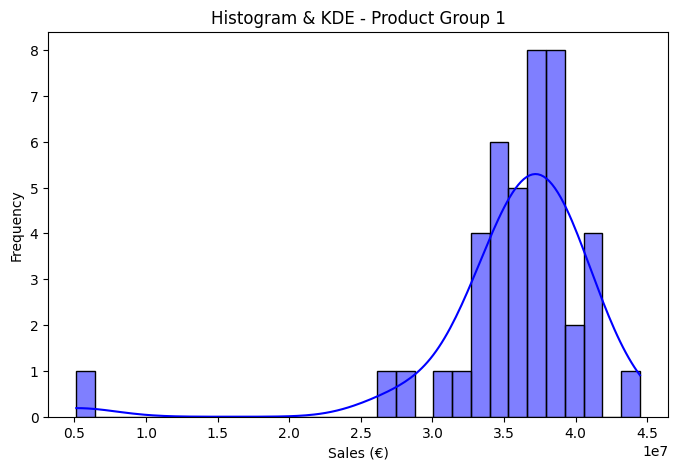

In [50]:
plot_distribution(sales_agg1['Sales_EUR'], product_group=1)

In [51]:
adf_result1 = adf_test(sales_agg1['Sales_EUR'], product_group=1)

Augmented Dickey-Fuller (ADF) Test - Product Group 1
ADF Statistic: -6.002443
p-value: 0.000000
Critical Values:
	1%: -3.597
	5%: -2.933
	10%: -2.605

✅ The p-value (0.000000) is ≤ 0.05.
   We **reject** the null hypothesis, meaning the data is **stationary**.



# Product Group 3

In [52]:
sales_agg3 = get_sales_by_product_group(df_sales, product_group=3)
sales_agg3.head()

,DATE,Sales_EUR
0,2018-10-01,8089465.96
1,2018-11-01,11863001.51
2,2018-12-01,8736859.39
3,2019-01-01,10705300.63
4,2019-02-01,10167796.86


In [53]:
shapiro_result3 = shapiro_wilk_test(sales_agg3['Sales_EUR'])

Shapiro-Wilk Test for Normality:
Statistic: 0.963334
p-value: 0.183396

✅ The p-value (0.183396) is greater than 0.05.
   We fail to reject the null hypothesis, meaning the data appears normally distributed.



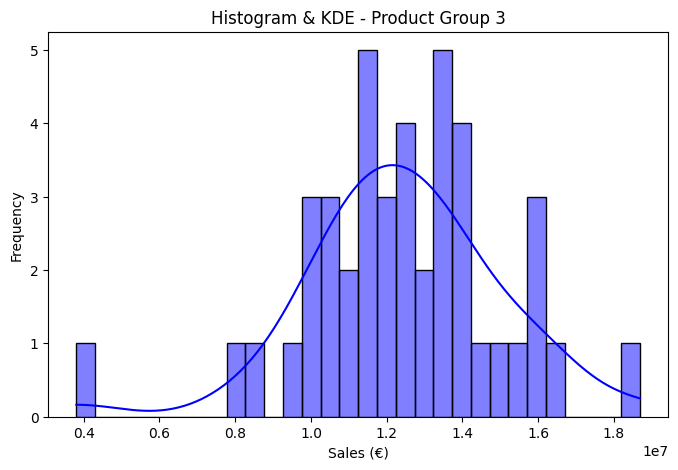

In [54]:
plot_distribution(sales_agg3['Sales_EUR'], product_group=3)

In [55]:
adf_result3 = adf_test(sales_agg3['Sales_EUR'], product_group=3)

Augmented Dickey-Fuller (ADF) Test - Product Group 3
ADF Statistic: -6.590291
p-value: 0.000000
Critical Values:
	1%: -3.597
	5%: -2.933
	10%: -2.605

✅ The p-value (0.000000) is ≤ 0.05.
   We **reject** the null hypothesis, meaning the data is **stationary**.



# Product Group 4

In [56]:
sales_agg4 = get_sales_by_product_group(df_sales, product_group=4)
sales_agg4.head()

,DATE,Sales_EUR
0,2018-10-01,397760.69
1,2018-11-01,371322.42
2,2018-12-01,430100.96
3,2019-01-01,484173.88
4,2019-02-01,620031.80


In [57]:
shapiro_result4 = shapiro_wilk_test(sales_agg4['Sales_EUR'])

Shapiro-Wilk Test for Normality:
Statistic: 0.912683
p-value: 0.003105

❌ The p-value (0.003105) is less than 0.05.
   We reject the null hypothesis, meaning the data is not normally distributed.



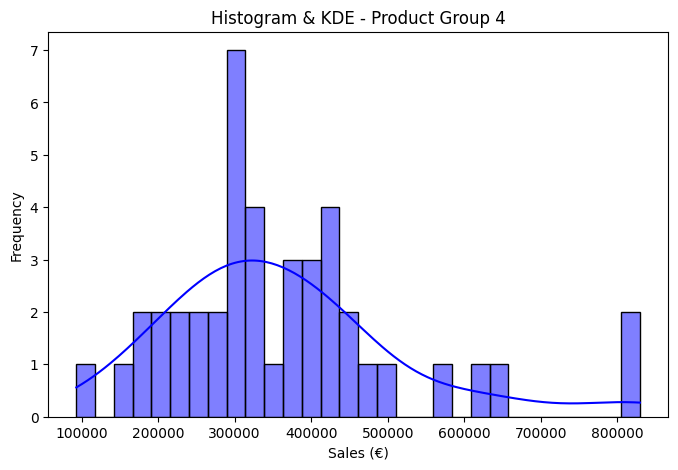

In [58]:
plot_distribution(sales_agg4['Sales_EUR'], product_group=4)

In [59]:
adf_result4 = adf_test(sales_agg4['Sales_EUR'], product_group=4)

Augmented Dickey-Fuller (ADF) Test - Product Group 4
ADF Statistic: -5.319293
p-value: 0.000005
Critical Values:
	1%: -3.597
	5%: -2.933
	10%: -2.605

✅ The p-value (0.000005) is ≤ 0.05.
   We **reject** the null hypothesis, meaning the data is **stationary**.



# Product Group 5

In [60]:
sales_agg5 = get_sales_by_product_group(df_sales, product_group=5)
sales_agg5.head()

,DATE,Sales_EUR
0,2018-10-01,2499061.19
1,2018-11-01,8993944.04
2,2018-12-01,6947507.31
3,2019-01-01,8233205.07
4,2019-02-01,6879250.99


In [61]:
shapiro_result5 = shapiro_wilk_test(sales_agg5['Sales_EUR'])

Shapiro-Wilk Test for Normality:
Statistic: 0.983178
p-value: 0.771690

✅ The p-value (0.771690) is greater than 0.05.
   We fail to reject the null hypothesis, meaning the data appears normally distributed.



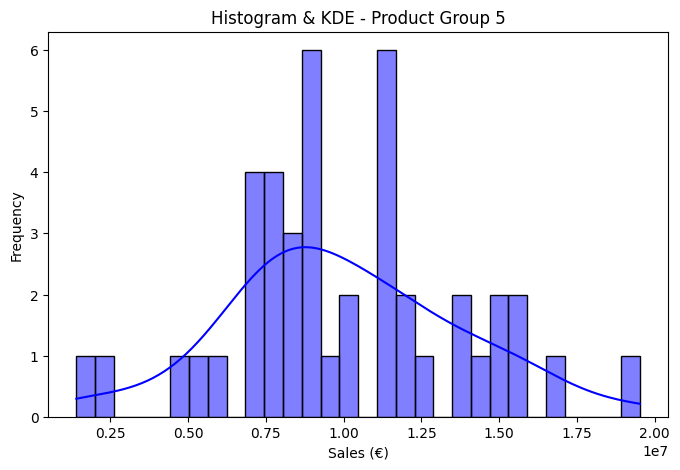

In [62]:
plot_distribution(sales_agg5['Sales_EUR'], product_group=5)

In [63]:
adf_result5 = adf_test(sales_agg5['Sales_EUR'], product_group=5)

Augmented Dickey-Fuller (ADF) Test - Product Group 5
ADF Statistic: -7.636228
p-value: 0.000000
Critical Values:
	1%: -3.597
	5%: -2.933
	10%: -2.605

✅ The p-value (0.000000) is ≤ 0.05.
   We **reject** the null hypothesis, meaning the data is **stationary**.



# Product Group 6

In [64]:
sales_agg6 = get_sales_by_product_group(df_sales, product_group=6)
sales_agg6.head()

,DATE,Sales_EUR
0,2018-10-01,369231.60
1,2018-11-01,473046.96
2,2018-12-01,999472.69
3,2019-01-01,598874.10
4,2019-02-01,542037.52


In [65]:
shapiro_result6 = shapiro_wilk_test(sales_agg6['Sales_EUR'])

Shapiro-Wilk Test for Normality:
Statistic: 0.981259
p-value: 0.697078

✅ The p-value (0.697078) is greater than 0.05.
   We fail to reject the null hypothesis, meaning the data appears normally distributed.



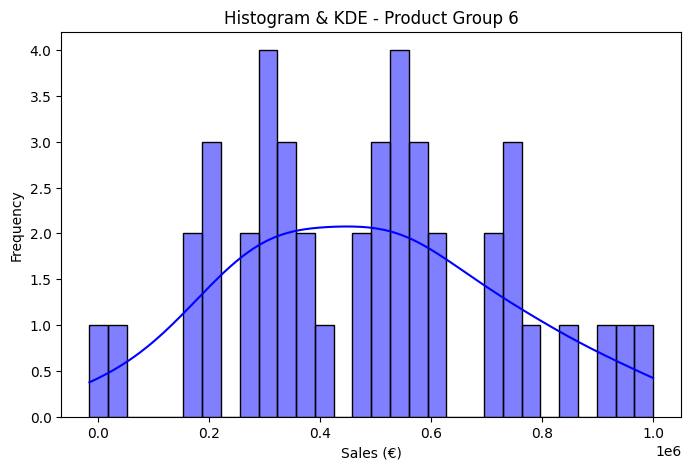

In [66]:
plot_distribution(sales_agg6['Sales_EUR'], product_group=6)

In [67]:
adf_result6 = adf_test(sales_agg6['Sales_EUR'], product_group=6)

Augmented Dickey-Fuller (ADF) Test - Product Group 6
ADF Statistic: -3.477762
p-value: 0.008577
Critical Values:
	1%: -3.601
	5%: -2.935
	10%: -2.606

✅ The p-value (0.008577) is ≤ 0.05.
   We **reject** the null hypothesis, meaning the data is **stationary**.



# Product Group 8

In [68]:
sales_agg8 = get_sales_by_product_group(df_sales, product_group=8)
sales_agg8.head()

,DATE,Sales_EUR
0,2018-10-01,586052.74
1,2018-11-01,526292.77
2,2018-12-01,271490.71
3,2019-01-01,381400.15
4,2019-02-01,368475.57


In [69]:
shapiro_result8 = shapiro_wilk_test(sales_agg8['Sales_EUR'])

Shapiro-Wilk Test for Normality:
Statistic: 0.888547
p-value: 0.000572

❌ The p-value (0.000572) is less than 0.05.
   We reject the null hypothesis, meaning the data is not normally distributed.



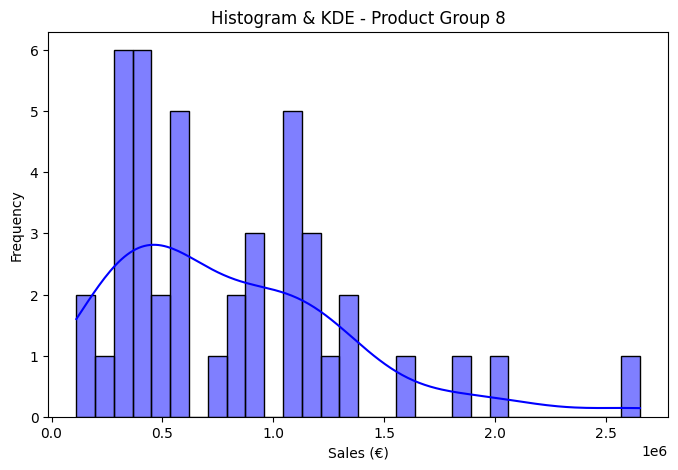

In [70]:
plot_distribution(sales_agg8['Sales_EUR'], product_group=8)

In [71]:
adf_result8 = adf_test(sales_agg8['Sales_EUR'], product_group=8)

Augmented Dickey-Fuller (ADF) Test - Product Group 8
ADF Statistic: 2.340859
p-value: 0.998980
Critical Values:
	1%: -3.627
	5%: -2.946
	10%: -2.612

❌ The p-value (0.998980) is > 0.05.
   We **fail to reject** the null hypothesis, meaning the data is **non-stationary**.



### Differencing Necessary

the sales data was **non-stationary**, likely due to a trend. Stationarity is important for forecasting models, which assume constant statistical properties over time.  

To address this, we applied **first-order differencing**, which removes trends by converting absolute sales values into **changes over time**

This transformation **stabilized the mean** and removed trend-based dependencies.


In [72]:
# First-Order Differencing (Removes Trend)
sales_agg8['Sales_EUR_Diff'] = sales_agg8['Sales_EUR'].diff()

In [ ]:
# Drop the missing values resulted from differencing (the first row, that did not have a previous value to subtract)
sales_agg8 = sales_agg8.dropna(subset=['Sales_EUR_Diff'])

In [ ]:
# Retest ADF after differencing
adf_result8_diff = adf_test(sales_agg8['Sales_EUR_Diff'], product_group=8)

Augmented Dickey-Fuller (ADF) Test - Product Group 8
ADF Statistic: -4.873763
p-value: 0.000039
Critical Values:
	1%: -3.627
	5%: -2.946
	10%: -2.612

✅ The p-value (0.000039) is ≤ 0.05.
   We **reject** the null hypothesis, meaning the data is **stationary**.



# Product Group 9

In [77]:
sales_agg9 = get_sales_by_product_group(df_sales, product_group=9)
sales_agg9.head()

,DATE,Sales_EUR
0,2018-10-01,3219.32
1,2018-11-01,1875.90
2,2018-12-01,0.00
3,2019-01-01,1487.00
4,2019-02-01,3234.28


In [78]:
shapiro_result9 = shapiro_wilk_test(sales_agg9['Sales_EUR'])

Shapiro-Wilk Test for Normality:
Statistic: 0.812044
p-value: 0.000007

❌ The p-value (0.000007) is less than 0.05.
   We reject the null hypothesis, meaning the data is not normally distributed.



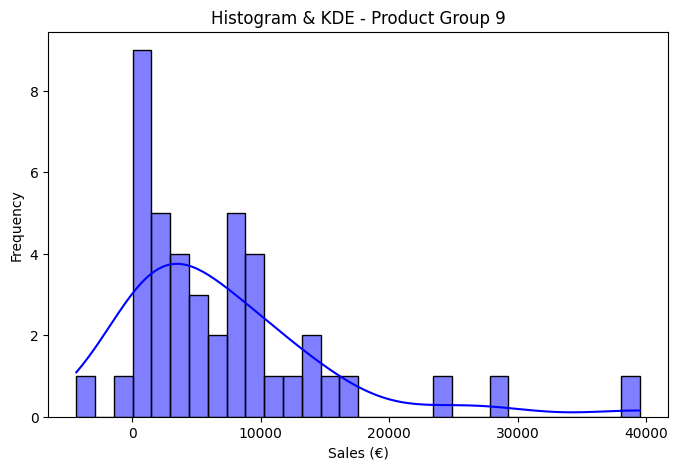

In [79]:
plot_distribution(sales_agg9['Sales_EUR'], product_group=9)

In [80]:
adf_result9 = adf_test(sales_agg9['Sales_EUR'], product_group=9)

Augmented Dickey-Fuller (ADF) Test - Product Group 9
ADF Statistic: -7.013494
p-value: 0.000000
Critical Values:
	1%: -3.597
	5%: -2.933
	10%: -2.605

✅ The p-value (0.000000) is ≤ 0.05.
   We **reject** the null hypothesis, meaning the data is **stationary**.



# Product Group 11

In [81]:
sales_agg11 = get_sales_by_product_group(df_sales, product_group=11)
sales_agg11.head()

,DATE,Sales_EUR
0,2018-10-01,1021303.50
1,2018-11-01,1898844.80
2,2018-12-01,1226122.00
3,2019-01-01,2216391.74
4,2019-02-01,610456.60


In [82]:
shapiro_result11 = shapiro_wilk_test(sales_agg11['Sales_EUR'])

Shapiro-Wilk Test for Normality:
Statistic: 0.935275
p-value: 0.017705

❌ The p-value (0.017705) is less than 0.05.
   We reject the null hypothesis, meaning the data is not normally distributed.



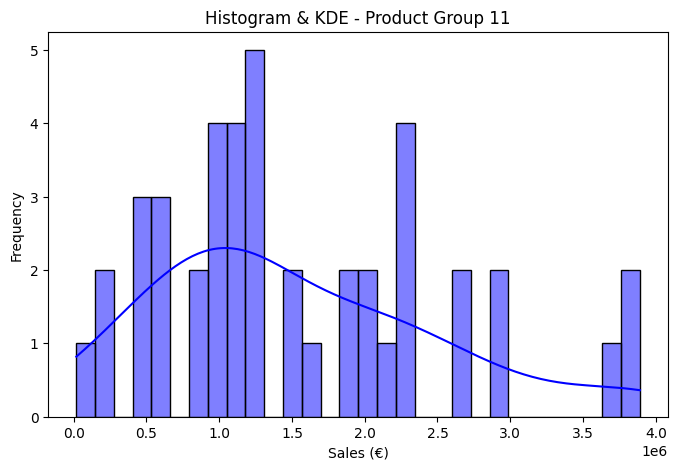

In [83]:
plot_distribution(sales_agg11['Sales_EUR'], product_group=11)

In [84]:
adf_result11 = adf_test(sales_agg11['Sales_EUR'], product_group=11)

Augmented Dickey-Fuller (ADF) Test - Product Group 11
ADF Statistic: -5.577923
p-value: 0.000001
Critical Values:
	1%: -3.601
	5%: -2.935
	10%: -2.606

✅ The p-value (0.000001) is ≤ 0.05.
   We **reject** the null hypothesis, meaning the data is **stationary**.



# Product Group 12

In [85]:
sales_agg12 = get_sales_by_product_group(df_sales, product_group=12)
sales_agg12.head()

,DATE,Sales_EUR
0,2018-10-01,28686.33
1,2018-11-01,1070.00
2,2018-12-01,17880.60
3,2019-01-01,21484.00
4,2019-02-01,34214.74


In [86]:
shapiro_result12 = shapiro_wilk_test(sales_agg12['Sales_EUR'])

Shapiro-Wilk Test for Normality:
Statistic: 0.920265
p-value: 0.005472

❌ The p-value (0.005472) is less than 0.05.
   We reject the null hypothesis, meaning the data is not normally distributed.



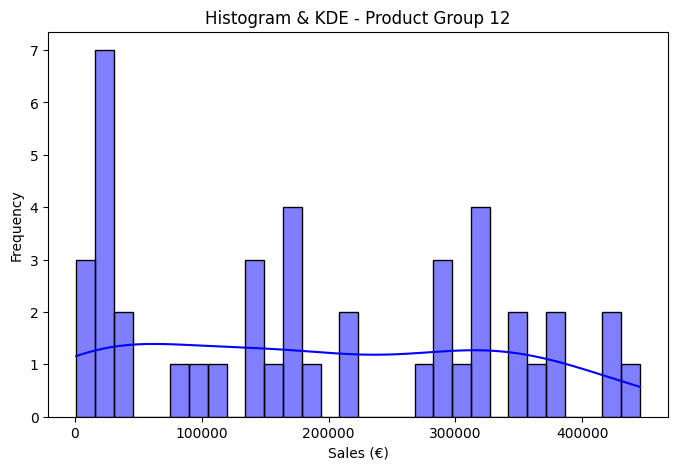

In [87]:
plot_distribution(sales_agg12['Sales_EUR'], product_group=12)

In [88]:
adf_result12 = adf_test(sales_agg12['Sales_EUR'], product_group=12)

Augmented Dickey-Fuller (ADF) Test - Product Group 12
ADF Statistic: -3.869337
p-value: 0.002272
Critical Values:
	1%: -3.597
	5%: -2.933
	10%: -2.605

✅ The p-value (0.002272) is ≤ 0.05.
   We **reject** the null hypothesis, meaning the data is **stationary**.



# Product Group 13

In [89]:
sales_agg13 = get_sales_by_product_group(df_sales, product_group=13)
sales_agg13.head()

,DATE,Sales_EUR
0,2018-10-01,27666.10
1,2018-11-01,68180.00
2,2018-12-01,15655.18
3,2019-01-01,27198.29
4,2019-02-01,32638.63


In [90]:
shapiro_result13 = shapiro_wilk_test(sales_agg13['Sales_EUR'])

Shapiro-Wilk Test for Normality:
Statistic: 0.900989
p-value: 0.001341

❌ The p-value (0.001341) is less than 0.05.
   We reject the null hypothesis, meaning the data is not normally distributed.



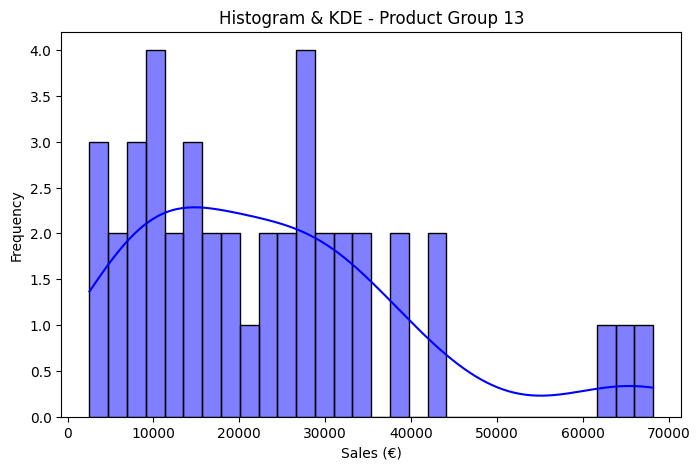

In [91]:
plot_distribution(sales_agg13['Sales_EUR'], product_group=13)

In [92]:
adf_result13 = adf_test(sales_agg13['Sales_EUR'], product_group=13)

Augmented Dickey-Fuller (ADF) Test - Product Group 13
ADF Statistic: -3.254199
p-value: 0.017054
Critical Values:
	1%: -3.606
	5%: -2.937
	10%: -2.607

✅ The p-value (0.017054) is ≤ 0.05.
   We **reject** the null hypothesis, meaning the data is **stationary**.



# Product Group 14

In [93]:
sales_agg14 = get_sales_by_product_group(df_sales, product_group=14)
sales_agg14.head()

,DATE,Sales_EUR
0,2018-10-01,5770.0
1,2018-11-01,17130.0
2,2018-12-01,0.0
3,2019-01-01,1686.4
4,2019-02-01,19196.3


In [94]:
shapiro_result14 = shapiro_wilk_test(sales_agg14['Sales_EUR'])

Shapiro-Wilk Test for Normality:
Statistic: 0.686922
p-value: 0.000000

❌ The p-value (0.000000) is less than 0.05.
   We reject the null hypothesis, meaning the data is not normally distributed.



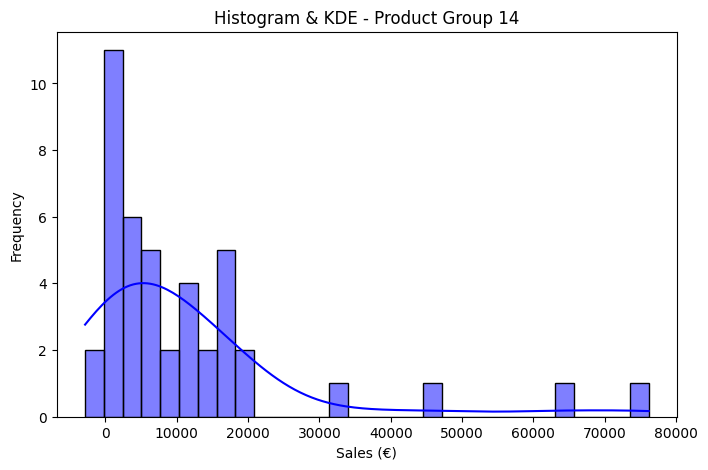

In [95]:
plot_distribution(sales_agg14['Sales_EUR'], product_group=14)

In [96]:
adf_result14 = adf_test(sales_agg14['Sales_EUR'], product_group=14)

Augmented Dickey-Fuller (ADF) Test - Product Group 14
ADF Statistic: -6.871822
p-value: 0.000000
Critical Values:
	1%: -3.597
	5%: -2.933
	10%: -2.605

✅ The p-value (0.000000) is ≤ 0.05.
   We **reject** the null hypothesis, meaning the data is **stationary**.



# Product Group 16

In [97]:
sales_agg16 = get_sales_by_product_group(df_sales, product_group=16)
sales_agg16.head()

,DATE,Sales_EUR
0,2018-10-01,333196.87
1,2018-11-01,1377694.32
2,2018-12-01,4762524.66
3,2019-01-01,942957.19
4,2019-02-01,257765.04


In [98]:
shapiro_result16 = shapiro_wilk_test(sales_agg16['Sales_EUR'])

Shapiro-Wilk Test for Normality:
Statistic: 0.429564
p-value: 0.000000

❌ The p-value (0.000000) is less than 0.05.
   We reject the null hypothesis, meaning the data is not normally distributed.



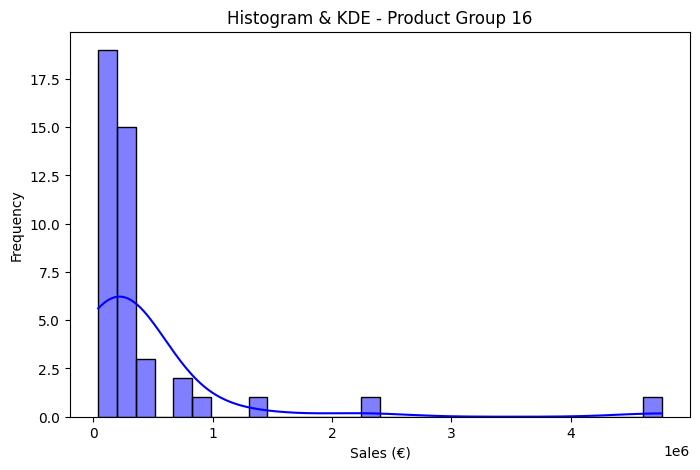

In [99]:
plot_distribution(sales_agg16['Sales_EUR'], product_group=16)

In [100]:
adf_result16 = adf_test(sales_agg16['Sales_EUR'], product_group=16)

Augmented Dickey-Fuller (ADF) Test - Product Group 16
ADF Statistic: -6.367204
p-value: 0.000000
Critical Values:
	1%: -3.646
	5%: -2.954
	10%: -2.616

✅ The p-value (0.000000) is ≤ 0.05.
   We **reject** the null hypothesis, meaning the data is **stationary**.



# Product Group 20

In [101]:
sales_agg20 = get_sales_by_product_group(df_sales, product_group=20)
sales_agg20.head()

,DATE,Sales_EUR
0,2018-10-01,4563.14
1,2018-11-01,5798.14
2,2018-12-01,918.65
3,2019-01-01,2398.04
4,2019-02-01,620.66


In [102]:
shapiro_result20 = shapiro_wilk_test(sales_agg20['Sales_EUR'])

Shapiro-Wilk Test for Normality:
Statistic: 0.745145
p-value: 0.000000

❌ The p-value (0.000000) is less than 0.05.
   We reject the null hypothesis, meaning the data is not normally distributed.



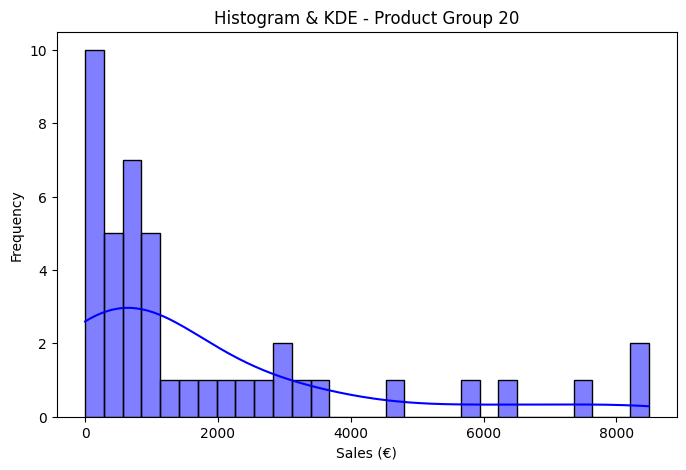

In [103]:
plot_distribution(sales_agg20['Sales_EUR'], product_group=20)

In [104]:
adf_result20 = adf_test(sales_agg20['Sales_EUR'], product_group=20)

Augmented Dickey-Fuller (ADF) Test - Product Group 20
ADF Statistic: -3.125179
p-value: 0.024745
Critical Values:
	1%: -3.601
	5%: -2.935
	10%: -2.606

✅ The p-value (0.024745) is ≤ 0.05.
   We **reject** the null hypothesis, meaning the data is **stationary**.



# Product Group 36

In [105]:
sales_agg36 = get_sales_by_product_group(df_sales, product_group=36)
sales_agg36.head()

,DATE,Sales_EUR
0,2018-10-01,6474.60
1,2018-11-01,21617.61
2,2018-12-01,13924.52
3,2019-01-01,15444.39
4,2019-02-01,8051.15


In [106]:
shapiro_result36 = shapiro_wilk_test(sales_agg36['Sales_EUR'])

Shapiro-Wilk Test for Normality:
Statistic: 0.433648
p-value: 0.000000

❌ The p-value (0.000000) is less than 0.05.
   We reject the null hypothesis, meaning the data is not normally distributed.



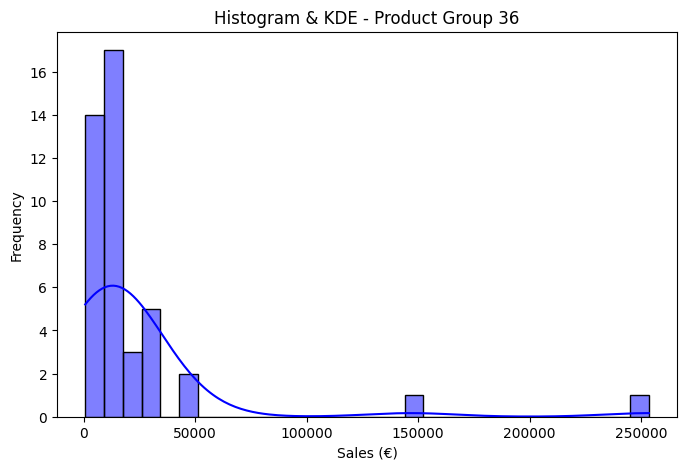

In [107]:
plot_distribution(sales_agg36['Sales_EUR'], product_group=36)

In [108]:
adf_result36 = adf_test(sales_agg36['Sales_EUR'], product_group=36)

Augmented Dickey-Fuller (ADF) Test - Product Group 36
ADF Statistic: -7.000027
p-value: 0.000000
Critical Values:
	1%: -3.597
	5%: -2.933
	10%: -2.605

✅ The p-value (0.000000) is ≤ 0.05.
   We **reject** the null hypothesis, meaning the data is **stationary**.

